In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

random_state=42

tf.random.set_seed(random_state)

In [ ]:
# wandb integration
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In our models, we use the number of cases in the last n days as input features to predict the output of next day. n is a hyperparameter whose value is set to 7,10 and 14 and the losses for each are compared.

In [ ]:
df_save = pd.DataFrame(columns=['7', '10', '14'])

## Data formatting - Using past 7 days

In [ ]:
n_past = 7
n_future = 1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/cleaned.csv', index_col='Day')

In [ ]:
def select_columns(df):
  cols_to_keep = [       
      'Daily Confirmed'      
  ]
  df_subset = df[cols_to_keep]
#   df_subset[i] = df_subset[i].rolling(window=7).mean().iloc[7-1:]
  return len(cols_to_keep), df_subset

In [ ]:
n_features, df_2 = select_columns(df)
df_3 = df_2.copy(deep=True)

In [ ]:
train_df, test_df = df_2[:400], df_3[400-n_past+1:]

In [ ]:
# scaling training data to (0,1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

# transfoming testing data on the training data
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

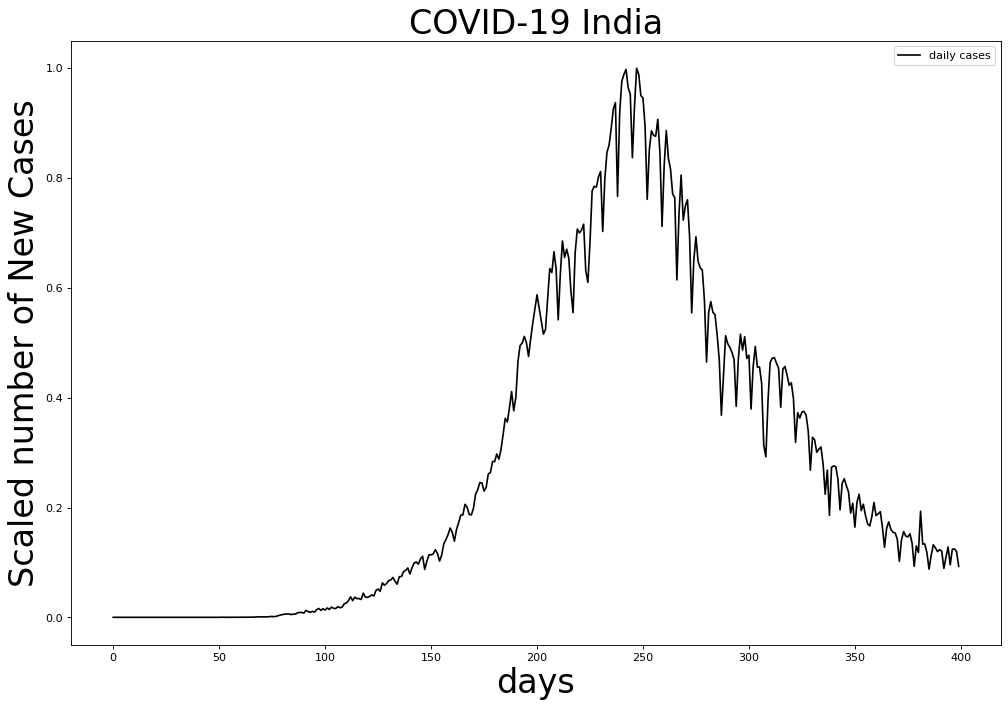

In [ ]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train['Daily Confirmed'].values,color = 'black', label = 'daily cases')

plt.xlabel("days", fontsize=30)
plt.ylabel("Scaled number of New Cases", fontsize=30)
plt.title("COVID-19 India", fontsize=30)
plt.legend()

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_test.shape

(55, 7, 1)

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(256,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(256, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_7 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_7.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  [(None, 7, 256), (No 264192      input_6[0][0]                    
__________________________________________________________________________________________________
lstm_21 (LSTM)                  [(None, 256), (None, 525312      lstm_20[0][0]                    
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 1, 256)       0           lstm_21[0][0]                    
____________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 1. Start a new run
wandb.init(project='seq2seq_final', entity='covid19india')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.random_state = random_state

model_7.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError(), 
                             keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
history_7=model_7.fit(X_train,y_train,epochs=50,validation_split=0.3,batch_size=16,verbose=0,callbacks=[reduce_lr, WandbCallback()])

epoch,49
loss,0.00076
mean_squared_error,0.00152
root_mean_squared_error,0.03903
mean_absolute_error,0.02043
mean_absolute_percentage_error,13426.31348
val_loss,0.00138
val_mean_squared_error,0.00276
val_root_mean_squared_error,0.05257
val_mean_absolute_error,0.03972
val_mean_absolute_percentage_error,17.34605


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_percentage_error,█▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▂▂▄▃▁▂▂▅▅▃▃▂▂▂▄▄▂▃▅▃▃▂▃▂▂▂▂▃▄▂▃▃▂▃▂
val_mean_squared_error,█▁▁▁▂▂▂▄▃▁▂▂▅▅▃▃▂▂▂▄▄▂▃▅▃▃▂▃▂▂▂▂▃▄▂▃▃▂▃▂
val_root_mean_squared_error,█▁▁▁▂▃▃▅▄▁▂▃▆▆▃▄▂▂▃▄▅▃▄▆▄▃▂▄▂▃▃▂▄▄▂▃▄▂▃▃
val_mean_absolute_error,█▁▁▁▂▂▃▅▄▁▂▃▆▆▃▄▂▂▃▄▅▃▄▆▄▃▂▄▂▃▂▂▄▄▂▃▄▂▃▃
val_mean_absolute_percentage_error,█▁▁▁▂▃▃▅▅▁▂▃▆▆▄▄▃▃▃▅▅▃▄▆▄▄▂▄▂▃▃▂▄▅▃▄▅▂▄▃


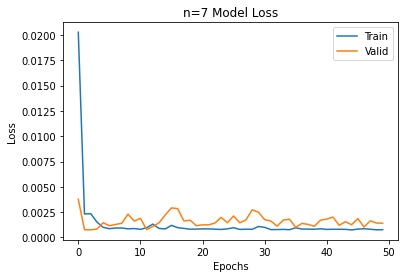

In [ ]:
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title("n=7 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
test_pred_7=model_7.predict(X_test)
train_pred_7=model_7.predict(X_train)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    test_pred_7[:,:,index]=scaler.inverse_transform(test_pred_7[:,:,index])
    train_pred_7[:,:,index]=scaler.inverse_transform(train_pred_7[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    print("Train MAE-7 : ",mean_absolute_error(y_train[:,0,index],train_pred_7[:,0,index]))
    print("Test MAE-7 : ",mean_absolute_error(y_test[:,0,index],test_pred_7[:,0,index]))

Daily Confirmed
Train MAE-7 :  2589.201477031368
Test MAE-7 :  9719.561647727272


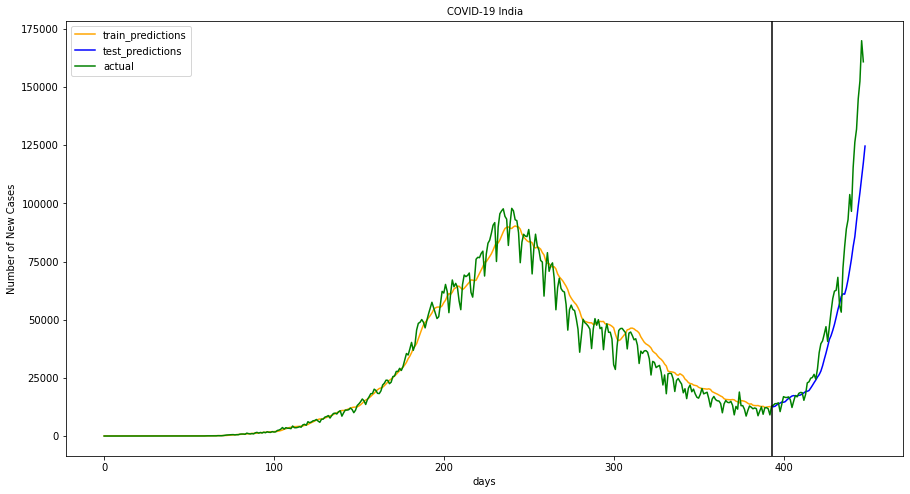

In [ ]:
plt.figure(figsize=(15,8))

true = np.append(y_train[:,0,-1], y_test[:,0,-1])
plt.plot(train_pred_7[:,0,-1],color = 'orange', label = 'train_predictions')
plt.plot(range(train_pred_7.shape[0]+1,true.shape[0]+1), test_pred_7[:,0,-1],color = 'blue', label = 'test_predictions')
plt.plot(true,color = 'green', label = 'actual')
plt.xlabel("days", fontsize=10)
plt.ylabel("Number of New Cases", fontsize=10)
plt.title("COVID-19 India", fontsize=10)
plt.axvline(x=train_pred_7.shape[0], color='black')
plt.legend()
wandb.log({"actual_vs_predicted": wandb.Image(plt)})

In [ ]:
df_save['7'] = test_pred_7.reshape(-1)

## Data formatting - Using past 10 days

In [ ]:
n_past = 10
n_future = 1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/cleaned.csv', index_col='Day')

In [ ]:
def select_columns(df):
  cols_to_keep = [       
      'Daily Confirmed'      
  ]
  df_subset = df[cols_to_keep]
#   df_subset[i] = df_subset[i].rolling(window=7).mean().iloc[7-1:]
  return len(cols_to_keep), df_subset

In [ ]:
n_features, df_2 = select_columns(df)
df_3 = df_2.copy(deep=True)

In [ ]:
train_df, test_df = df_2[:400], df_3[400-n_past+1:]

In [ ]:
# scaling training data to (0,1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

# transfoming testing data on the training data
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

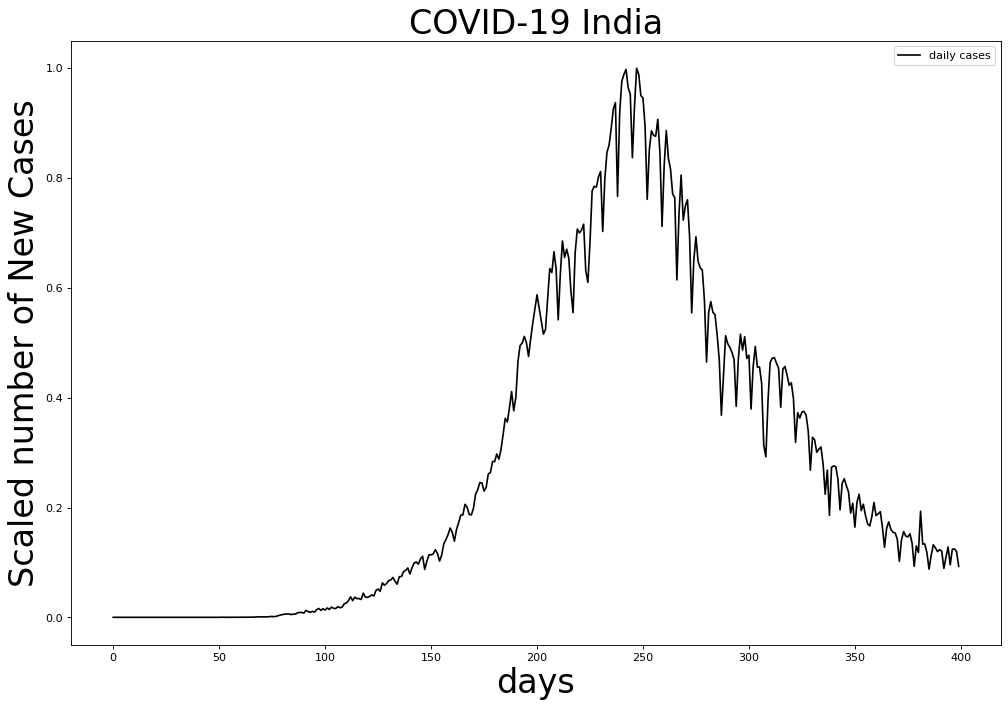

In [ ]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train['Daily Confirmed'].values,color = 'black', label = 'daily cases')

plt.xlabel("days", fontsize=30)
plt.ylabel("Scaled number of New Cases", fontsize=30)
plt.title("COVID-19 India", fontsize=30)
plt.legend()

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(256,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(256, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_10 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_10.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  [(None, 10, 256), (N 264192      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_25 (LSTM)                  [(None, 256), (None, 525312      lstm_24[0][0]                    
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 1, 256)       0           lstm_25[0][0]                    
____________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 1. Start a new run
wandb.init(project='seq2seq_final', entity='covid19india')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.random_state = random_state

model_10.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError(), 
                             keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
history_10=model_10.fit(X_train,y_train,epochs=50,validation_split=0.3,batch_size=16,verbose=0,callbacks=[reduce_lr, WandbCallback()])

epoch,49
loss,0.00077
mean_squared_error,0.00154
root_mean_squared_error,0.03919
mean_absolute_error,0.02052
mean_absolute_percentage_error,14271.9707
val_loss,0.00141
val_mean_squared_error,0.00282
val_root_mean_squared_error,0.05307
val_mean_absolute_error,0.04028
val_mean_absolute_percentage_error,17.58361


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_percentage_error,█▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▂▃▅▄▁▂▃▆▆▃▃▂▂▃▄▄▃▃▆▃▃▂▃▂▂▂▂▃▄▂▃▄▂▃▃
val_mean_squared_error,█▁▁▁▂▂▃▅▄▁▂▃▆▆▃▃▂▂▃▄▄▃▃▆▃▃▂▃▂▂▂▂▃▄▂▃▄▂▃▃
val_root_mean_squared_error,█▁▁▁▂▃▃▅▄▁▂▃▆▆▄▄▃▃▃▅▅▃▄▆▄▄▂▄▂▃▃▂▄▅▂▃▄▂▄▃
val_mean_absolute_error,█▁▁▁▂▃▃▅▄▁▂▃▇▇▄▄▂▃▃▅▅▃▄▆▄▄▂▄▂▃▃▂▄▅▂▃▄▂▄▃
val_mean_absolute_percentage_error,█▁▁▁▃▃▄▆▅▁▂▄▇▇▄▄▃▃▃▅▅▄▄▇▄▄▃▄▂▃▃▂▅▅▃▄▅▂▄▃


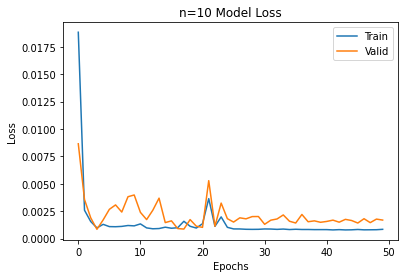

In [ ]:
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title("n=10 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
test_pred_10=model_10.predict(X_test)
train_pred_10=model_10.predict(X_train)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    test_pred_10[:,:,index]=scaler.inverse_transform(test_pred_10[:,:,index])
    train_pred_10[:,:,index]=scaler.inverse_transform(train_pred_10[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    # print("Train MAE-10 : ",mean_absolute_error(y_train[:,0,index],train_pred_10[:,0,index]))
    print("Test MAE-10 : ",mean_absolute_error(y_test[:,0,index],test_pred_10[:,0,index]))
    # print("Train MAE-10 : ",mean_squared_error(y_train[:,0,index],train_pred_10[:,0,index], squared=False))
    print("Test MAE-10 : ",mean_squared_error(y_test[:,0,index],test_pred_10[:,0,index], squared=False))

Daily Confirmed
Test MAE-10 :  8972.07109375
Test MAE-10 :  14672.892711163991


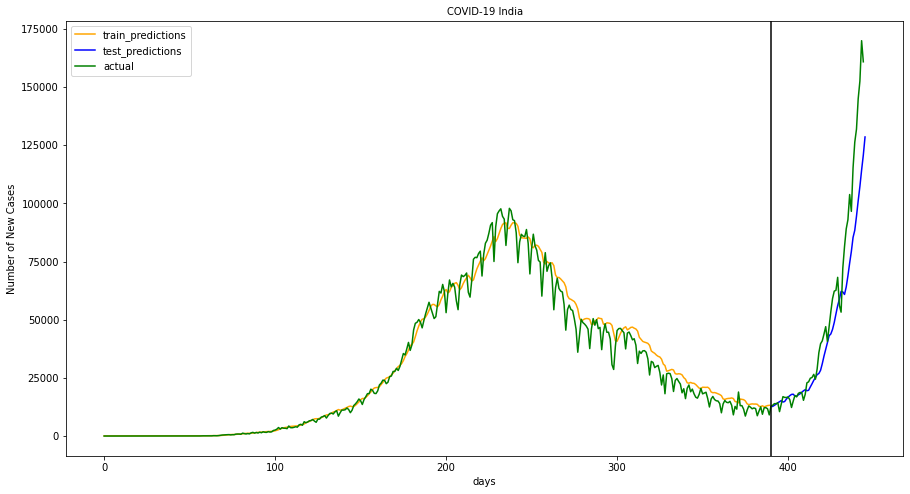

In [ ]:
plt.figure(figsize=(15,8))

true = np.append(y_train[:,0,-1], y_test[:,0,-1])
plt.plot(train_pred_10[:,0,-1],color = 'orange', label = 'train_predictions')
plt.plot(range(train_pred_10.shape[0]+1,true.shape[0]+1), test_pred_10[:,0,-1],color = 'blue', label = 'test_predictions')
plt.plot(true,color = 'green', label = 'actual')
plt.xlabel("days", fontsize=10)
plt.ylabel("Number of New Cases", fontsize=10)
plt.title("COVID-19 India", fontsize=10)
plt.axvline(x=train_pred_10.shape[0], color='black')
plt.legend()
wandb.log({"actual_vs_predicted": wandb.Image(plt)})

In [ ]:
df_save['10'] = test_pred_10.reshape(-1)

## Data formatting - Using past 7 days

In [ ]:
n_past = 14
n_future = 1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/cleaned.csv', index_col='Day')

In [ ]:
def select_columns(df):
  cols_to_keep = [       
      'Daily Confirmed'      
  ]
  df_subset = df[cols_to_keep]
#   df_subset[i] = df_subset[i].rolling(window=7).mean().iloc[7-1:]
  return len(cols_to_keep), df_subset

In [ ]:
n_features, df_2 = select_columns(df)
df_3 = df_2.copy(deep=True)

In [ ]:
train_df, test_df = df_2[:400], df_3[400-n_past+1:]

In [ ]:
# scaling training data to (0,1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

# transfoming testing data on the training data
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

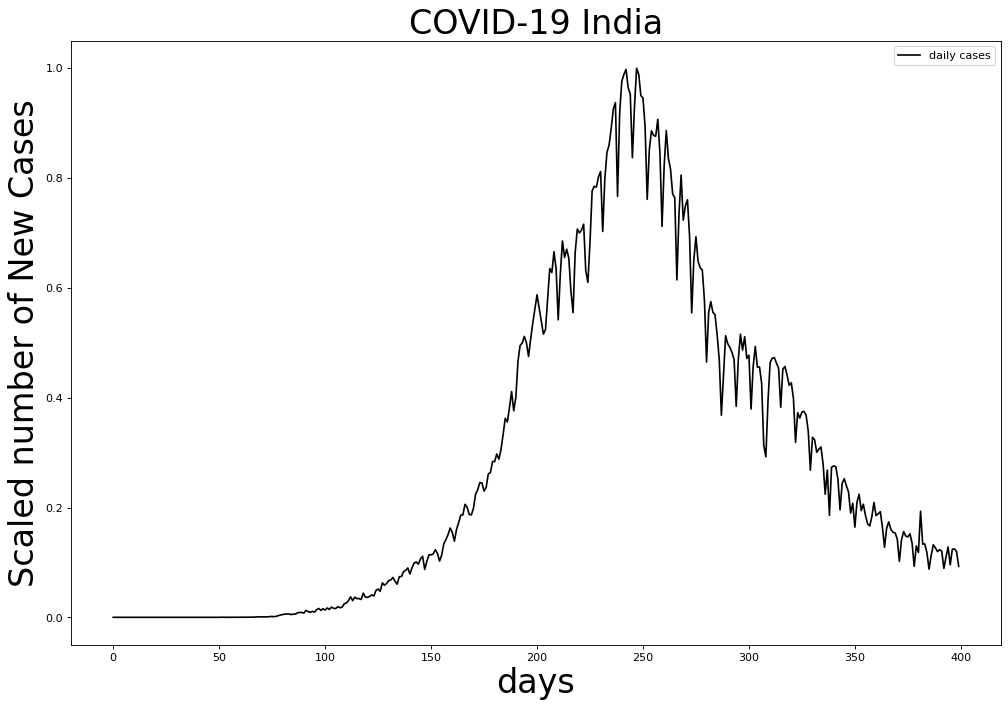

In [ ]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train['Daily Confirmed'].values,color = 'black', label = 'daily cases')

plt.xlabel("days", fontsize=30)
plt.ylabel("Scaled number of New Cases", fontsize=30)
plt.title("COVID-19 India", fontsize=30)
plt.legend()

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(256,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(256, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_14 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_14.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
lstm_28 (LSTM)                  [(None, 14, 256), (N 264192      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_29 (LSTM)                  [(None, 256), (None, 525312      lstm_28[0][0]                    
__________________________________________________________________________________________________
repeat_vector_7 (RepeatVector)  (None, 1, 256)       0           lstm_29[0][0]                    
____________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 1. Start a new run
wandb.init(project='seq2seq_final', entity='covid19india')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.random_state = random_state

model_14.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError(), 
                             keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
history_14=model_14.fit(X_train,y_train,epochs=50,validation_split=0.3,batch_size=16,verbose=0,callbacks=[reduce_lr, WandbCallback()])

epoch,49
loss,0.00084
mean_squared_error,0.00168
root_mean_squared_error,0.04094
mean_absolute_error,0.02134
mean_absolute_percentage_error,34396.31641
val_loss,0.00168
val_mean_squared_error,0.00337
val_root_mean_squared_error,0.05801
val_mean_absolute_error,0.04495
val_mean_absolute_percentage_error,19.70848


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▂▁▂▂▂▁▁▁▁▁▂▁▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_percentage_error,█▂▂▁▂▂▂▁▁▁▁▁▂▂▂▂▂▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▃▃▂▄▂▂▃▄▂▁▁▂▁▅▁▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_mean_squared_error,█▃▂▁▃▃▂▄▂▂▃▄▂▁▁▂▁▅▁▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_root_mean_squared_error,█▄▃▁▃▄▃▅▃▂▃▄▂▁▁▂▁▆▁▄▂▃▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂
val_mean_absolute_error,█▄▃▁▃▄▃▅▃▂▃▄▂▁▁▂▁▆▁▄▂▃▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂
val_mean_absolute_percentage_error,█▄▃▁▄▄▃▅▃▂▃▄▂▁▁▂▁▆▂▄▂▃▃▃▂▂▃▃▂▃▂▂▂▂▂▂▂▃▂▂


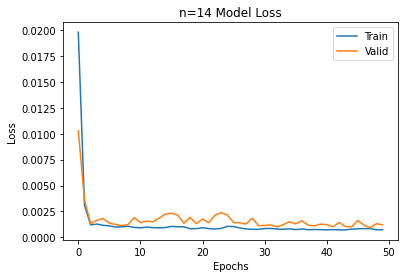

In [ ]:
plt.plot(history_14.history['loss'])
plt.plot(history_14.history['val_loss'])
plt.title("n=14 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
test_pred_14=model_14.predict(X_test)
train_pred_14=model_14.predict(X_train)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    test_pred_14[:,:,index]=scaler.inverse_transform(test_pred_14[:,:,index])
    train_pred_14[:,:,index]=scaler.inverse_transform(train_pred_14[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    print("Train MAE-14 : ",mean_absolute_error(y_train[:,0,index],train_pred_14[:,0,index]))
    print("Test MAE-14 : ",mean_absolute_error(y_test[:,0,index],test_pred_14[:,0,index]))

Daily Confirmed
Train MAE-14 :  2391.5292632036258
Test MAE-14 :  7439.943980823864


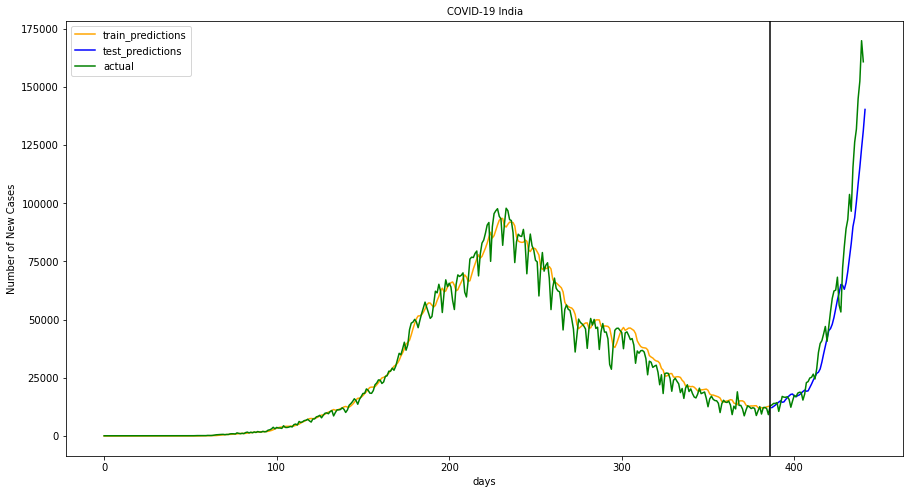

In [ ]:
plt.figure(figsize=(15,8))

true = np.append(y_train[:,0,-1], y_test[:,0,-1])
plt.plot(train_pred_14[:,0,-1],color = 'orange', label = 'train_predictions')
plt.plot(range(train_pred_14.shape[0]+1,true.shape[0]+1), test_pred_14[:,0,-1],color = 'blue', label = 'test_predictions')
plt.plot(true,color = 'green', label = 'actual')
plt.xlabel("days", fontsize=10)
plt.ylabel("Number of New Cases", fontsize=10)
plt.title("COVID-19 India", fontsize=10)
plt.axvline(x=train_pred_14.shape[0], color='black')
plt.legend()
wandb.log({"actual_vs_predicted": wandb.Image(plt)})

In [ ]:
df_save['14'] = test_pred_14.reshape(-1)

In [ ]:
df_save.to_csv('/content/drive/MyDrive/Major Project/seq2seq.csv')
# df = pd.read_csv('/content/drive/MyDrive/ML/cleaned.csv', index_col='Day')

In [ ]:
df_save

,7,10,14
0,12593.253906,12741.331055,12120.815430
1,12796.948242,13194.272461,12619.261719
2,13379.168945,13719.403320,13196.019531
3,13783.500000,14298.420898,13880.552734
4,14155.291016,14749.728516,14475.575195
5,14610.715820,15230.394531,15033.615234
6,14509.601562,14606.946289,14411.097656
7,14766.116211,14841.626953,14574.773438
8,15538.102539,15883.137695,15605.487305
9,16172.772461,16718.017578,16434.328125


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    # print("Train MAE-10 : ",mean_absolute_error(y_train[:,0,index],train_pred_10[:,0,index]))
    print("Test MAE-10 : ",mean_absolute_error(y_test[:,0,index],test_pred_10[:,0,index]))
    # print("Train MAE-10 : ",mean_squared_error(y_train[:,0,index],train_pred_10[:,0,index], squared=False))
    print("Test MAE-10 : ",mean_squared_error(y_test[:,0,index],test_pred_10[:,0,index], squared=False))

Daily Confirmed
Test MAE-10 :  8972.07109375
Test MAE-10 :  14672.892711163991


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    # print("Train MAE-10 : ",mean_absolute_error(y_train[:,0,index],train_pred_10[:,0,index]))
    print("Test MAE-7 : ",mean_absolute_error(y_test[:,0,index],test_pred_7[:,0,index]))
    # print("Train MAE-7 : ",mean_squared_error(y_train[:,0,index],train_pred_7[:,0,index], squared=False))
    print("Test MAE-7 : ",mean_squared_error(y_test[:,0,index],test_pred_7[:,0,index], squared=False))

Daily Confirmed
Test MAE-7 :  9719.561647727272
Test MAE-7 :  15945.435787135797


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
for index,i in enumerate(train_df.columns):
    print(i)
    # print("Train MAE-10 : ",mean_absolute_error(y_train[:,0,index],train_pred_10[:,0,index]))
    print("Test MAE-14 : ",mean_absolute_error(y_test[:,0,index],test_pred_14[:,0,index]))
    # print("Train MAE-14 : ",mean_squared_error(y_train[:,0,index],train_pred_14[:,0,index], squared=False))
    print("Test MAE-14 : ",mean_squared_error(y_test[:,0,index],test_pred_14[:,0,index], squared=False))

Daily Confirmed
Test MAE-14 :  7439.943980823864
Test MAE-14 :  11669.858087371975
